This is a demo script that trains the unsupervised domain adaptive Y-Net segmentation technique, as proposed in [1], for mitochondria segmentation in electron microscopy data. 

1. Joris Roels, Julian Hennies, Yvan Saeys, Wilfried Philips, Anna Kreshuk, ["Domain adaptive segmentation in volume electron microscopy imaging"](https://arxiv.org/abs/1810.09734), ISBI 2019.

Let's start with importing the required packages. 

In [1]:
%matplotlib inline
import argparse
import datetime
import os

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from neuralnets.data.datasets import StronglyLabeledVolumeDataset, UnlabeledVolumeDataset
from neuralnets.util.losses import CrossEntropyLoss, MSELoss
from neuralnets.util.preprocessing import get_augmenter2d
from neuralnets.util.validation import validate
from neuralnets.util.tools import set_seed, overlay
from neuralnets.util.metrics import jaccard, accuracy_metrics
from torch.utils.data import DataLoader

from networks.ynet import YNet2D

set_seed(0)

Let's start by loading the data and a quick visualisation! 

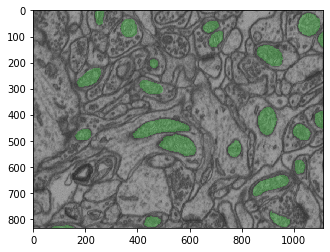

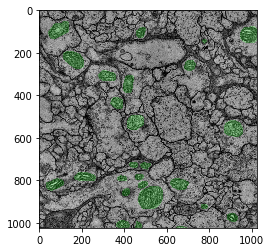

In [2]:
# source data
data_dir = '../data'

# size of the input
input_shape = (1, 128, 128)

# augmenters
augmenter_src = get_augmenter2d(input_shape[1:], include_segmentation=True)
augmenter_tar = get_augmenter2d(input_shape[1:], include_segmentation=False)

# normalize the voxel resolution
res_src = (1,5,5)
res_tar = (1,4.6,4.6)
scaling = np.divide(res_src, res_tar)

# load the data
train_src = StronglyLabeledVolumeDataset(os.path.join(data_dir, 'EM/EPFL/training.tif'),
                                         os.path.join(data_dir, 'EM/EPFL/training_groundtruth.tif'),
                                         input_shape=input_shape, scaling=scaling)
train_tar = UnlabeledVolumeDataset(os.path.join(data_dir, 'EM/VNC/data_larger.tif'),
                                   input_shape=input_shape)
test_src = StronglyLabeledVolumeDataset(os.path.join(data_dir, 'EM/EPFL/testing.tif'),
                                        os.path.join(data_dir, 'EM/EPFL/testing_groundtruth.tif'),
                                        input_shape=input_shape, scaling=scaling)
test_tar = StronglyLabeledVolumeDataset(os.path.join(data_dir, 'EM/VNC/data.tif'),
                                        os.path.join(data_dir, 'EM/VNC/mito_labels.tif'),
                                        input_shape=input_shape)

# show examples
plt.imshow(overlay(train_src.data[0,...],train_src.labels[0,...], alpha=0.2))
plt.show()
plt.imshow(overlay(test_tar.data[0,...],test_tar.labels[0,...], alpha=0.2))
plt.show()

Pretty similar data.. we will use the EPFL dataset as source, and the VNC data as target. Let's put this data in a dataloader for easy use in PyTorch. We will use a batch size of 2 for training and testing. You can make this smaller or larger depending on your computational resources. 

In [3]:
batch_size = 2

train_loader_src = DataLoader(train_src, batch_size=batch_size)
train_loader_tar = DataLoader(train_tar, batch_size=batch_size)
test_loader_src = DataLoader(test_src, batch_size=batch_size)
test_loader_tar = DataLoader(test_tar, batch_size=batch_size)

We are now ready to define and train the network! For computational simplicity, we will use a slightly smaller version of the original Y-Net. We will train the network with cross entropy and MSE loss for 10 epochs with learning rate of 0.001 with multiplicative decay (decay factor 0.9) every epoch. We will test the network after every epoch and print out some logging statistics every 50 iterations. The regularization parameter for the reconstruction loss is set to 0.001. 

In [4]:
feature_maps = 16
levels = 4
lambda_rec = 1e-3
net = YNet2D(feature_maps=feature_maps, levels=levels, lambda_rec=lambda_rec)

lr = 1e-3
step_size = 1
gamma = 0.9
epochs = 10
test_freq = 1
print_stats = 50
log_dir = "logs"

loss_seg_fn = CrossEntropyLoss()
loss_rec_fn = MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

net.train_net_unsupervised(train_loader_src, train_loader_tar, test_loader_src, test_loader_tar,
                           loss_seg_fn, loss_rec_fn, optimizer, epochs, scheduler=scheduler,
                           augmenter_src=augmenter_src, augmenter_tar=augmenter_tar, print_stats=print_stats,
                           log_dir=log_dir)

[2019-09-18 14:36:59.575210] Epoch     0/   10
[2019-09-18 14:36:59.621993] Epoch     0 - Iteration     0/  500 - Loss seg: 0.750744 - Loss rec: 0.043233 - Loss: 0.750787
[2019-09-18 14:37:02.355523] Epoch     0 - Iteration    50/  500 - Loss seg: 0.333037 - Loss rec: 0.026150 - Loss: 0.333063
[2019-09-18 14:37:05.198564] Epoch     0 - Iteration   100/  500 - Loss seg: 0.355056 - Loss rec: 0.028087 - Loss: 0.355084
[2019-09-18 14:37:07.806120] Epoch     0 - Iteration   150/  500 - Loss seg: 0.315980 - Loss rec: 0.025294 - Loss: 0.316006
[2019-09-18 14:37:10.432058] Epoch     0 - Iteration   200/  500 - Loss seg: 0.205597 - Loss rec: 0.031033 - Loss: 0.205628
[2019-09-18 14:37:13.248859] Epoch     0 - Iteration   250/  500 - Loss seg: 0.115933 - Loss rec: 0.031446 - Loss: 0.115964
[2019-09-18 14:37:15.830555] Epoch     0 - Iteration   300/  500 - Loss seg: 0.085682 - Loss rec: 0.028110 - Loss: 0.085710
[2019-09-18 14:37:18.413041] Epoch     0 - Iteration   350/  500 - Loss seg: 0.141770

[2019-09-18 14:40:20.916764] Epoch     5 - Iteration   300/  500 - Loss seg: 0.088578 - Loss rec: 0.023637 - Loss: 0.088602
[2019-09-18 14:40:23.542276] Epoch     5 - Iteration   350/  500 - Loss seg: 0.102996 - Loss rec: 0.027251 - Loss: 0.103023
[2019-09-18 14:40:26.210502] Epoch     5 - Iteration   400/  500 - Loss seg: 0.021931 - Loss rec: 0.030870 - Loss: 0.021962
[2019-09-18 14:40:28.823955] Epoch     5 - Iteration   450/  500 - Loss seg: 0.011492 - Loss rec: 0.029290 - Loss: 0.011522
[2019-09-18 14:40:31.385822] Epoch     5 - Loss seg: 0.063401 - Loss rec: 0.027011 - Loss: 0.063428
[2019-09-18 14:40:41.967893] Epoch     5 - Loss seg: 0.059687 - Loss rec: 0.027012 - Loss: 0.059714
[2019-09-18 14:40:42.129785] Epoch     6/   10
[2019-09-18 14:40:42.169168] Epoch     6 - Iteration     0/  500 - Loss seg: 0.079390 - Loss rec: 0.028165 - Loss: 0.079418
[2019-09-18 14:40:44.788738] Epoch     6 - Iteration    50/  500 - Loss seg: 0.040229 - Loss rec: 0.029086 - Loss: 0.040258
[2019-09-

Great! We will show reconstruction and segmentation results on the first slice of the target test dataset and validate it! 

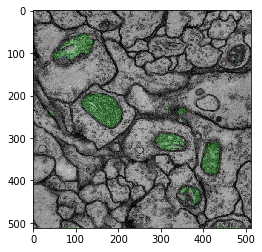

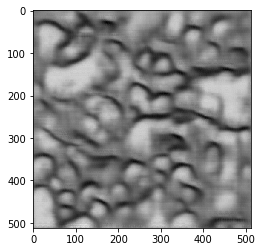

Validation results:
     Jaccard: 0.497497
     Accuracy: 0.950214
     Precision: 0.952034
     Recall: 0.510288
     F-score: 0.664438


In [5]:
test_data = test_tar.data[0:1,:512,:512]
test_labels = test_tar.labels[0:1,:512,:512]

test_data_rec, test_data_seg = net(torch.Tensor(test_data[np.newaxis,...]).cuda())
test_data_rec = test_data_rec[0,...].data.cpu().numpy()
test_data_seg = test_data_seg[0,...].data.cpu().numpy()
segmentation = test_data_seg[1, ...]>0.5

plt.imshow(overlay(test_data[0, ...], segmentation, alpha=0.2))
plt.show()
plt.imshow(test_data_rec[0, ...], cmap='gray')
plt.show()

j = jaccard(segmentation, test_labels)
a, p, r, f = accuracy_metrics(segmentation, test_labels)
print('Validation results:')
print('     Jaccard: %f' % (j))
print('     Accuracy: %f' % (a))
print('     Precision: %f' % (p))
print('     Recall: %f' % (r))
print('     F-score: %f' % (f))

Of course the results can be improved significantly by increasing the capacity of the network and tuning the hyperparameters. 